In [91]:

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random

from matplotlib import animation, rc
from IPython.display import HTML, Image

rc('animation', html='html5')
plt.ioff()

In [19]:
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.drawing.nx_agraph import to_agraph


graph = nx.DiGraph()

graph.add_node("a", cost=3)
graph.add_node("b", cost=8)
graph.add_node("c", cost=2)
graph.add_node("d", cost=2)
graph.add_node("e", cost=2)
graph.add_node("f", cost=6)
graph.add_node("g", cost=2)
graph.add_node("h", cost=2)
graph.add_node("i", cost=1)
graph.add_node("j", cost=1)

graph.add_edge("a", "b")
graph.add_edge("a", "c")
graph.add_edge("a", "d")

graph.add_edge("b", "e")
graph.add_edge("c", "f")
graph.add_edge("c", "g")
graph.add_edge("d", "g")

graph.add_edge("e", "h")
graph.add_edge("g", "i")
graph.add_edge("i", "j")


In [115]:
def process(graph):
    for node in graph.node:
        if 'cost' not in graph.node[node]:
            graph.node[node]['cost'] = 1 + int(random.random() * 10)
            
    root = random.choice([n for n in graph.node if graph.in_degree[n] == 0])
        
    for node in graph.node:
        ancestors = nx.ancestors(graph, node)
        cost = graph.node[node]['cost']
        in_deg = graph.in_degree[node]
        parents = set()
        for ancestor in ancestors:
            cost += graph.node[ancestor]['cost']
            parents.add(ancestor)
        graph.node[node]['true_cost'] = cost
        graph.node[node]['depth'] = len(nx.shortest_path(graph, root, node))
        graph.node[node]['parents'] = parents

In [111]:
class GraphTraversal(object):
    def __init__(self, graph, ax, max_ticks):
        self.graph = graph
        self.ax = ax
        
        self.color_map = {n: '#cccccc' for n in graph.node}
        self.node_progress = {}
        
        self.pos = graphviz_layout(self.graph, prog='dot', args='-Grankdir="LR" -Granksep="10" ')
        self.labels = {n: "{} ({})".format(n, self.prop(n, 'cost')) for n in graph.node}
        self.max_ticks = max_ticks

    def colors(self):
        return [self.color_map[n] for n in self.graph.node]
    
    def node(self, node_name):
        return self.graph.node[node_name]
    
    def prop(self, node_name, prop):
        return self.graph.node[node_name][prop]
    
    def in_progress(self, node_name):
        self.color_map[node_name] = '#FFE66D'
        self.node_progress[node_name] = 0
        
    def node_complete(self, node_name):
        self.color_map[node_name] = '#4ECDC4'
        self.nodes_to_process.remove(node_name)
        
    def render(self, i):
        if self.max_ticks and i > self.max_ticks:
            return
        
        self.ax.clear()
        nx.draw(self.graph,
                pos=self.pos,
                node_size=1500,
                node_color=self.colors(),
                arrows=True,
                node_shape="o",
                labels=self.labels,
                with_labels=True,
                ax=self.ax)
        self.ax.set_title("Time={}".format(i))
        self.ax.set_xticks([])
        self.ax.set_yticks([])
        

class NaiveGraphTraversal(GraphTraversal):
    def __init__(self, graph, ax, max_ticks=None):
        super(NaiveGraphTraversal, self).__init__(graph, ax, max_ticks)
        
        self.max_degrees = 0
        self.nodes_to_process = set()

    def update(self, i):
        if len(self.nodes_to_process) == 0:
            self.nodes_to_process = {n for n in self.graph.node if self.prop(n, 'depth') == self.max_degrees}
            self.max_degrees += 1

            for node in self.nodes_to_process:
                self.in_progress(node)

        if i > 0:
            for node in list(self.nodes_to_process):
                self.node_progress[node] += 1
                if self.node_progress[node] >= self.prop(node, 'cost'):
                    self.node_complete(node)
                    
        self.render(i)
        

class SmartGraphTraversal(GraphTraversal):
    def __init__(self, graph, ax, max_ticks=None):
        super(SmartGraphTraversal, self).__init__(graph, ax, max_ticks)
        
        self.nodes_to_process = set()
        self.completed_nodes = set()
        
    def can_run_node(self, node_name):
        ancestors = self.prop(node_name, 'parents')
        remaining_ancestors = len(ancestors.difference(self.completed_nodes))
        return remaining_ancestors == 0 and node_name not in self.completed_nodes

    def update(self, i):
        all_nodes_to_process = {n for n in self.graph.node if self.can_run_node(n)}
        new_nodes_to_process = all_nodes_to_process.difference(self.nodes_to_process)

        for node in new_nodes_to_process:
            self.in_progress(node)
            self.nodes_to_process.add(node)

        if i > 0:
            for node in list(self.nodes_to_process):
                self.node_progress[node] += 1
                if self.node_progress[node] >= self.prop(node, 'cost'):
                    self.node_complete(node)
                    self.completed_nodes.add(node)
                    
        self.render(i)

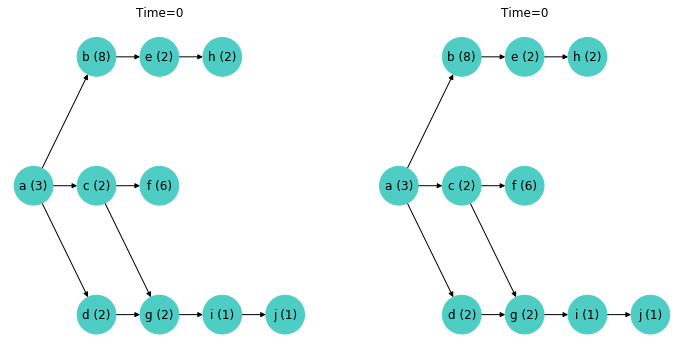

In [132]:
def render_example(graph):
    process(graph)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    naive_algo = NaiveGraphTraversal(graph, ax1)
    smart_algo = SmartGraphTraversal(graph, ax2, max_ticks=15)

    def update(i):
        naive_algo.update(i)
        smart_algo.update(i)

    animation = matplotlib.animation.FuncAnimation(fig, update, frames=21, interval=500, repeat=True)
    #return HTML(animation.to_jshtml())
    return animation
render_example(graph)

In [129]:
def render(graph, frames=21):
    process(graph)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), sharey=True)

    naive_algo = NaiveGraphTraversal(graph, ax1)
    smart_algo = SmartGraphTraversal(graph, ax2)

    def update(i):
        naive_algo.update(i)
        smart_algo.update(i)

    animation = matplotlib.animation.FuncAnimation(fig, update, frames=frames, interval=500, repeat=True)
    return HTML(animation.to_jshtml())

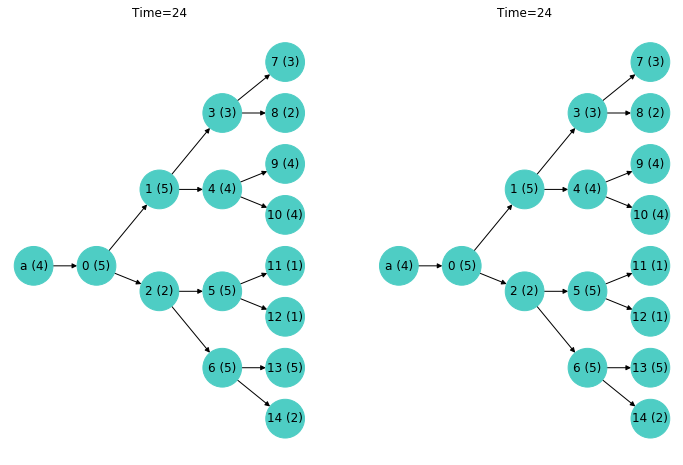

In [130]:
from networkx.generators.directed import gn_graph, random_k_out_graph
from networkx.generators.random_graphs import fast_gnp_random_graph
from networkx.generators.classic import balanced_tree

random_graph = balanced_tree(2, 3, create_using=nx.DiGraph)
random_graph.add_node('a')
random_graph.add_edge('a', 0)
render(random_graph, frames=25)